# Финальный проект

1. Мультивариативный ряд
2. Задача классификации или задача регрессии
3. Блок предобрабоки временного ряда
4. Не менее 3х способов выделения свойств из временного ряда
5. Не менее 2 классических  и 3 нейронок для прогнозирования (или классификации) временного ряда
6. Не менее 5 метрик по каждой модели
7. Выводы по каждой модели, и по результатам в целом.


Для работы используется датасет https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate?select=LSTM-Multivariate_pollution.csv

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

C:\Users\User\AppData\Local\Temp\ipykernel_18136\3998136994.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv('airPollution.csv')
data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


**Описание данных (eng)**

- Pollution: air pollution;
- No: row number;
- year: year of data in this row;
- month: month of data in this row;
- day: day of data in this row;
- hour: hour of data in this row;
- pm2.5: PM2.5 concentration;
- DEWP: Dew Point;
- TEMP: Temperature;
- PRES: Pressure;
- cbwd: Combined wind direction;
- Iws: Cumulated wind speed;
- Is: Cumulated hours of snow;
- Ir: Cumulated hours of rain;

In [4]:
data.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


#### Блок предобработки

In [5]:
# Проверка на наличие пропусков
if data.isnull().sum().sum() > 0:
    data.fillna(data.mean(), inplace=True) #заполнение средним значением
else:
    print("В данных нет пропусков")

В данных нет пропусков


In [6]:
data.dtypes

date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [7]:
#Преобазуем дату из object в datetime и для удобства делаем ее 
data['date'] = pd.to_datetime(data.date , format = '%Y-%m-%d %H:%M:%S')
data.index = data.date
data = data.drop(['date'], axis=1)
data.head()

# Преобразование категориальных данных в числовые
encoder = LabelEncoder()
data['wnd_dir'] = encoder.fit_transform(data['wnd_dir'])

In [8]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


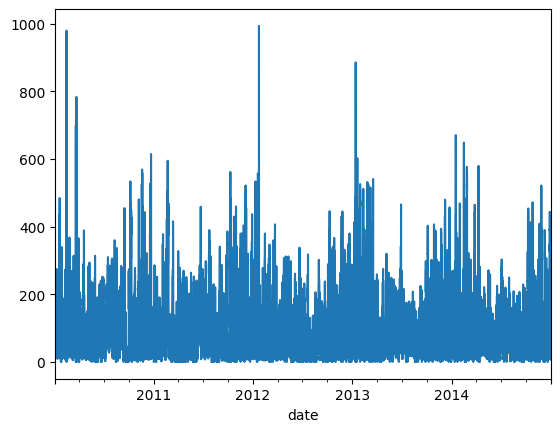

In [8]:
# Визуализация данных
data['pollution'].plot()
plt.show()

#### Блок выделения свойств

Тест Дики-Фуллера (проверка на Стационарность)

In [17]:
# Импортируем функцию для проведения теста Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

def testDickeyFuller(ts, name="Air Pollution", alpha=0.05):
    print(f'Тест Дики-Фуллера ряда {name} :')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [14]:
testDickeyFuller(data['pollution'])

Тест Дики-Фуллера ряда Air Pollution :
Test Statistic                   -21.004109
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43744.000000
Critical Value (1%)               -3.430499
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [6]:
df = data.copy()
df = df['pollution']

In [7]:
# Создаем выборку без тренда
nottrend = []
s = 3

# Создаем выборку без сезонности
notseason = []

# выборка без тренда
for i in range(1, len(df)):
   nottrend.append(df[i] - df[i-1])

# выборка без сезонности
for i in range(s, len(df)):
   notseason.append(df[i] - df[i-s])

C:\Users\User\AppData\Local\Temp\ipykernel_2100\601191643.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nottrend.append(df[i] - df[i-1])
C:\Users\User\AppData\Local\Temp\ipykernel_2100\601191643.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  notseason.append(df[i] - df[i-s])


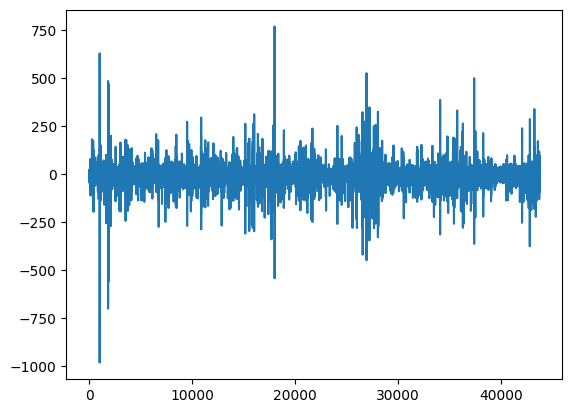

In [16]:
# Выводим график выборки без тренда
plt.plot(nottrend)

In [18]:
#Тест Дики-Фуллера для ряда без тренда
testDickeyFuller(nottrend, name="Air Pollution NO TRAND")

Тест Дики-Фуллера ряда Air Pollution NO TRAND :
Test Statistic                   -36.858517
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43743.000000
Critical Value (1%)               -3.430500
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


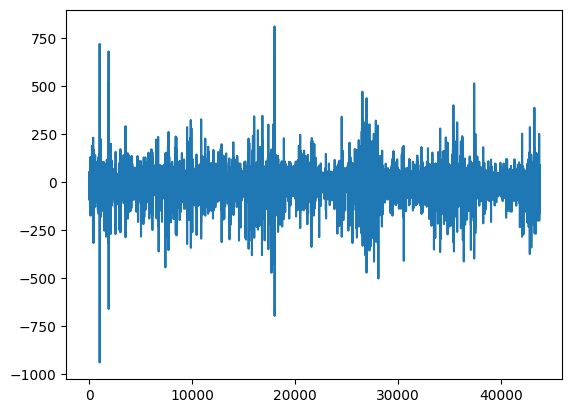

In [19]:
# Выводим график выборки без сезонности
plt.plot(notseason)

In [20]:
#Тест Дики-Фуллера для ряда без сезонности
testDickeyFuller(nottrend, name="Air Pollution NO SEASON")

Тест Дики-Фуллера ряда Air Pollution NO SEASON :
Test Statistic                   -36.858517
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43743.000000
Critical Value (1%)               -3.430500
Critical Value (5%)               -2.861606
Critical Value (10%)              -2.566805
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


**Автокорелляция и частичная автокорелляция**

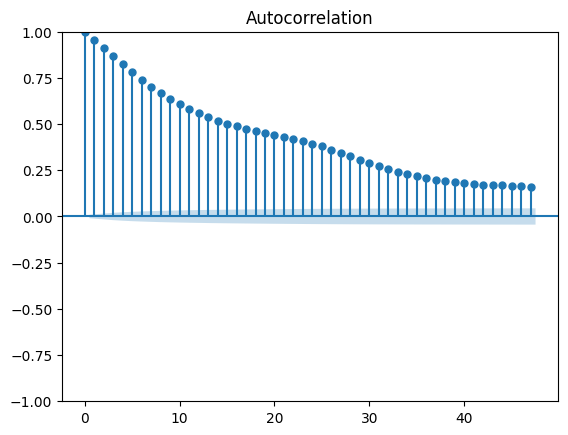

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

# Автокорреляция
plot_acf(df)
plt.show()

График показывает сильную автокорреляцию на начальных лагах, это указывает на то, что значения временного ряда тесно связаны с недавними значениями.
Влияние прошлых значений на текущее значение уменьшается с течением времени

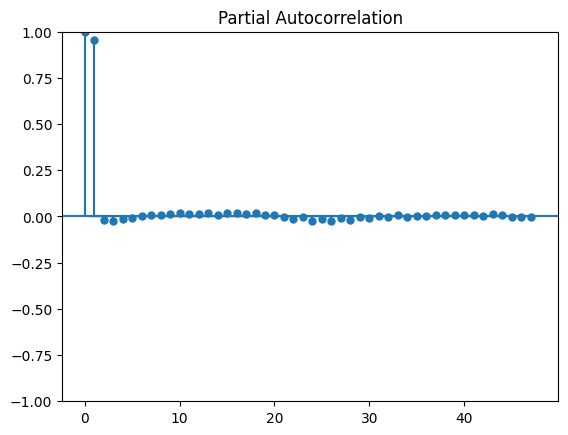

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

# Частичная автокорреляция
plot_pacf(df)
plt.show()

График показывает сильную автокорреляцию на первом лаге, после первого лага автокорреляция практически отсутствует

#### Блок предсказания

Исходя из стого, что ряд *pollution* стационарный, используем ARMA - авторегрессионную модель скользящего среднего

In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
arma_model = ARIMA(df, order=(5,0,3))
arma_model_fit = arma_model.fit()
print(arma_model_fit.summary())

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                43800
Model:                 ARIMA(5, 0, 3)   Log Likelihood             -206894.665
Date:                Thu, 21 Mar 2024   AIC                         413809.330
Time:                        20:13:36   BIC                         413896.204
Sample:                    01-02-2010   HQIC                        413836.711
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.0135      3.787     24.826      0.000      86.591     101.436
ar.L1          1.7066      0.394      4.328      0.000       0.934       2.479
ar.L2         -0.7877      0.895     -0.880      0.3

In [27]:
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = list(train[:])
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,0,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    print(output)
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[75.88805291]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[78.50435211]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[75.91510595]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[81.53653102]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[71.40745488]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[70.04747312]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[64.51373998]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[75.65492305]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[68.60206515]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[73.94022236]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[81.71384476]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[78.99593021]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[91.10579509]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[104.67241112]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[116.20370206]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[117.34718955]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[123.66759994]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[121.8636265]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[130.13007378]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[124.74071428]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[133.82663181]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[148.36065189]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[141.0708477]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[150.13686428]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[153.21274506]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[160.59525303]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[144.8741982]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[131.91239909]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[135.45398972]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[137.62827607]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[139.68541024]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[146.34119126]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[135.19354254]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[124.35832898]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[101.53189654]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[88.68322413]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[88.66044349]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[103.12823983]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[113.21201746]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[119.04603924]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[121.88527398]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[126.47888566]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[135.96457791]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[144.64958909]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[148.50334972]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[156.96040143]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[161.79564172]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[171.17263893]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[190.25005101]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[196.26906347]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[208.44011326]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[229.29276288]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[212.74715468]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[221.21628964]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[185.80354431]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[154.28918549]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[161.4430793]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[166.74323134]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[178.53721286]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[192.21913687]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[183.8913003]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[149.50944927]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[132.37085134]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[132.31006263]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[131.71878839]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[137.59742232]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[143.52611964]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[170.95601344]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[190.67491175]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[198.3570879]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[196.3505088]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[208.22720112]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[208.48680115]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[222.43897835]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[239.84573042]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[242.8433595]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[250.30329483]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[252.20750973]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[266.18574299]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[250.57561279]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[209.25738961]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[193.93690353]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[184.62819506]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[210.1439677]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[229.37813812]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[218.34366927]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[233.76747508]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[211.61499785]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[174.76586779]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[150.33788998]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[122.73539868]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[144.07030085]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[161.51780956]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[124.25007412]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[87.18470823]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[84.41831169]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[73.53906133]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[77.31149543]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[74.98247085]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[39.04424817]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[18.27180209]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[12.38744032]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[11.65499988]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[14.83144713]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[17.92011368]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[21.79196527]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[18.12870342]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[12.25258448]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[8.33039735]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[10.17098936]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[11.22277736]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[17.8918246]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[16.21651727]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[19.81428277]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[18.04303466]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[18.89466651]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[14.21600554]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[13.07803682]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[12.20527246]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[13.09305874]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[14.13593371]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[14.16254163]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[13.22205893]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[12.21444952]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[13.13252531]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[10.3897235]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[9.34540609]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[11.22441044]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[12.24499309]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[22.64172334]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[25.78986555]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[53.99234289]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[43.52749476]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[94.60384307]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[44.40680977]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[71.1197574]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[66.10736806]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[91.63113817]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[84.45572484]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[99.6259199]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[114.32113992]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[71.98512759]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[82.72297805]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[87.36510348]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[81.63011053]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[80.70289479]


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[80.67725053]


После очень долгого ожидания пришло понимание, что мой компьютер не способен достаточно быстро провести вычисления для модели ARMA. Слишком большой объем данных.

**Модель VAR** - статистическая модель, используемая для прогнозирования уровней временных рядов на основе их собственных исторических значений

In [18]:
# Для использования модели VAR все ряды должны быть статическими. Проведем их проверку с помощью теста Дики-Фуллера
for name, column in train.items():
    testDickeyFuller(column, name=column.name)
    print('\n\n')

Тест Дики-Фуллера ряда pollution :
Test Statistic                -1.680593e+01
p-value                        1.209784e-29
#Lags Used                     4.900000e+01
Number of Observations Used    2.885800e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861640e+00
Critical Value (10%)          -2.566823e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.



Тест Дики-Фуллера ряда dew :
Test Statistic                    -5.103332
p-value                            0.000014
#Lags Used                        48.000000
Number of Observations Used    28859.000000
Critical Value (1%)               -3.430577
Critical Value (5%)               -2.861640
Critical Value (10%)              -2.566823
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.



Тест Дики-Фуллера ряда temp :
Test Statistic                    -3.326188
p-value                            0.013748
#Lags Used                        49.000000
Number of Observations Used    28858.0

In [35]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [36]:
# Разделяем выборку на train и test
cdf = data.copy()

train = cdf[:int(0.8*(len(data)))]
test = cdf[int(0.8*(len(data))):]

In [37]:
# Создаем модель VAR на основе обучающих данных
model = VAR(train)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [38]:
# Выбираем порядок модели VAR, который минимизирует критерий информативности Акаике (AIC)
x = model.select_order(maxlags=100)

# Выводим информацию о выбранном порядке
x.summary()

,AIC,BIC,FPE,HQIC
0,28.82,28.82,3.270e+12,28.82
1,8.989,9.007,8017.,8.995
2,8.706,8.739,6038.,8.716
3,8.529,8.578,5061.,8.545
4,8.473,8.537,4784.,8.493
5,8.452,8.532,4686.,8.478
6,8.430,8.525,4583.,8.460
7,8.420,8.530,4536.,8.455
8,8.411,8.537,4498.,8.451
9,8.398,8.539,4438.,8.443


Подобрали подходящий порядок лагов

In [39]:
x.aic

54

На 54 порядке AIC меньше всего

In [41]:
# заполняем модель с подобранным параметром
model_fitted = model.fit(x.aic)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Mar, 2024
Time:                     14:40:55
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    8.86373
Nobs:                     34986.0    HQIC:                   8.29273
Log likelihood:          -534076.    FPE:                    3059.00
AIC:                      8.02583    Det(Omega_mle):         2772.32
--------------------------------------------------------------------
Results for equation pollution
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                61.610671        35.464763            1.737           0.082
L1.pollution          0.910097         0.005412          168.156           0.000
L1.dew                1.852374         0.117653         

In [42]:
# данные для предсказания
forecast_input = train.values[-x.aic:]
forecast_input

array([[ 0.0000e+00, -2.4000e+01,  2.0000e+00,  1.0160e+03,  2.0000e+00,
         2.4590e+01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3000e+01,  4.0000e+00,  1.0170e+03,  2.0000e+00,
         2.7720e+01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3000e+01,  1.0000e+00,  1.0170e+03,  2.0000e+00,
         2.9510e+01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3000e+01,  4.0000e+00,  1.0170e+03,  3.0000e+00,
         1.7900e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -1.8000e+01, -3.0000e+00,  1.0170e+03,  3.0000e+00,
         2.6800e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -1.7000e+01, -2.0000e+00,  1.0170e+03,  3.0000e+00,
         3.1300e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3000e+01,  3.0000e+00,  1.0170e+03,  1.0000e+00,
         4.9200e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3000e+01,  2.0000e+00,  1.0170e+03,  1.0000e+00,
         1.0730e+01,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.4000e+01

In [32]:
# Forecast
nobs = 365 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=cdf.index[-nobs:], columns=cdf.columns)
df_forecast

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-12-16 19:00:00,77.810540,-1.648854,12.816803,1021.288367,2.098568,4.790911,0.021467,-0.071600
2014-12-16 20:00:00,78.981201,-2.240654,13.544177,1020.504149,2.040865,6.074787,0.014531,0.002263
2014-12-16 21:00:00,78.990920,-2.481423,13.720299,1019.623128,2.164111,7.635472,0.073269,0.078726
2014-12-16 22:00:00,77.635215,-2.609089,13.459108,1018.812229,2.100780,9.111041,0.083002,0.098004
2014-12-16 23:00:00,77.245682,-2.441300,12.777692,1018.356049,1.950354,12.083766,0.109253,0.052311
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,94.011324,-1.384648,10.638171,1018.671371,1.631875,26.610330,0.088510,0.171380
2014-12-31 20:00:00,93.042610,-1.521555,11.012797,1018.365534,1.646391,27.159878,0.086865,0.172468
2014-12-31 21:00:00,92.052864,-1.617805,11.173747,1018.063147,1.653439,27.723258,0.082290,0.174238


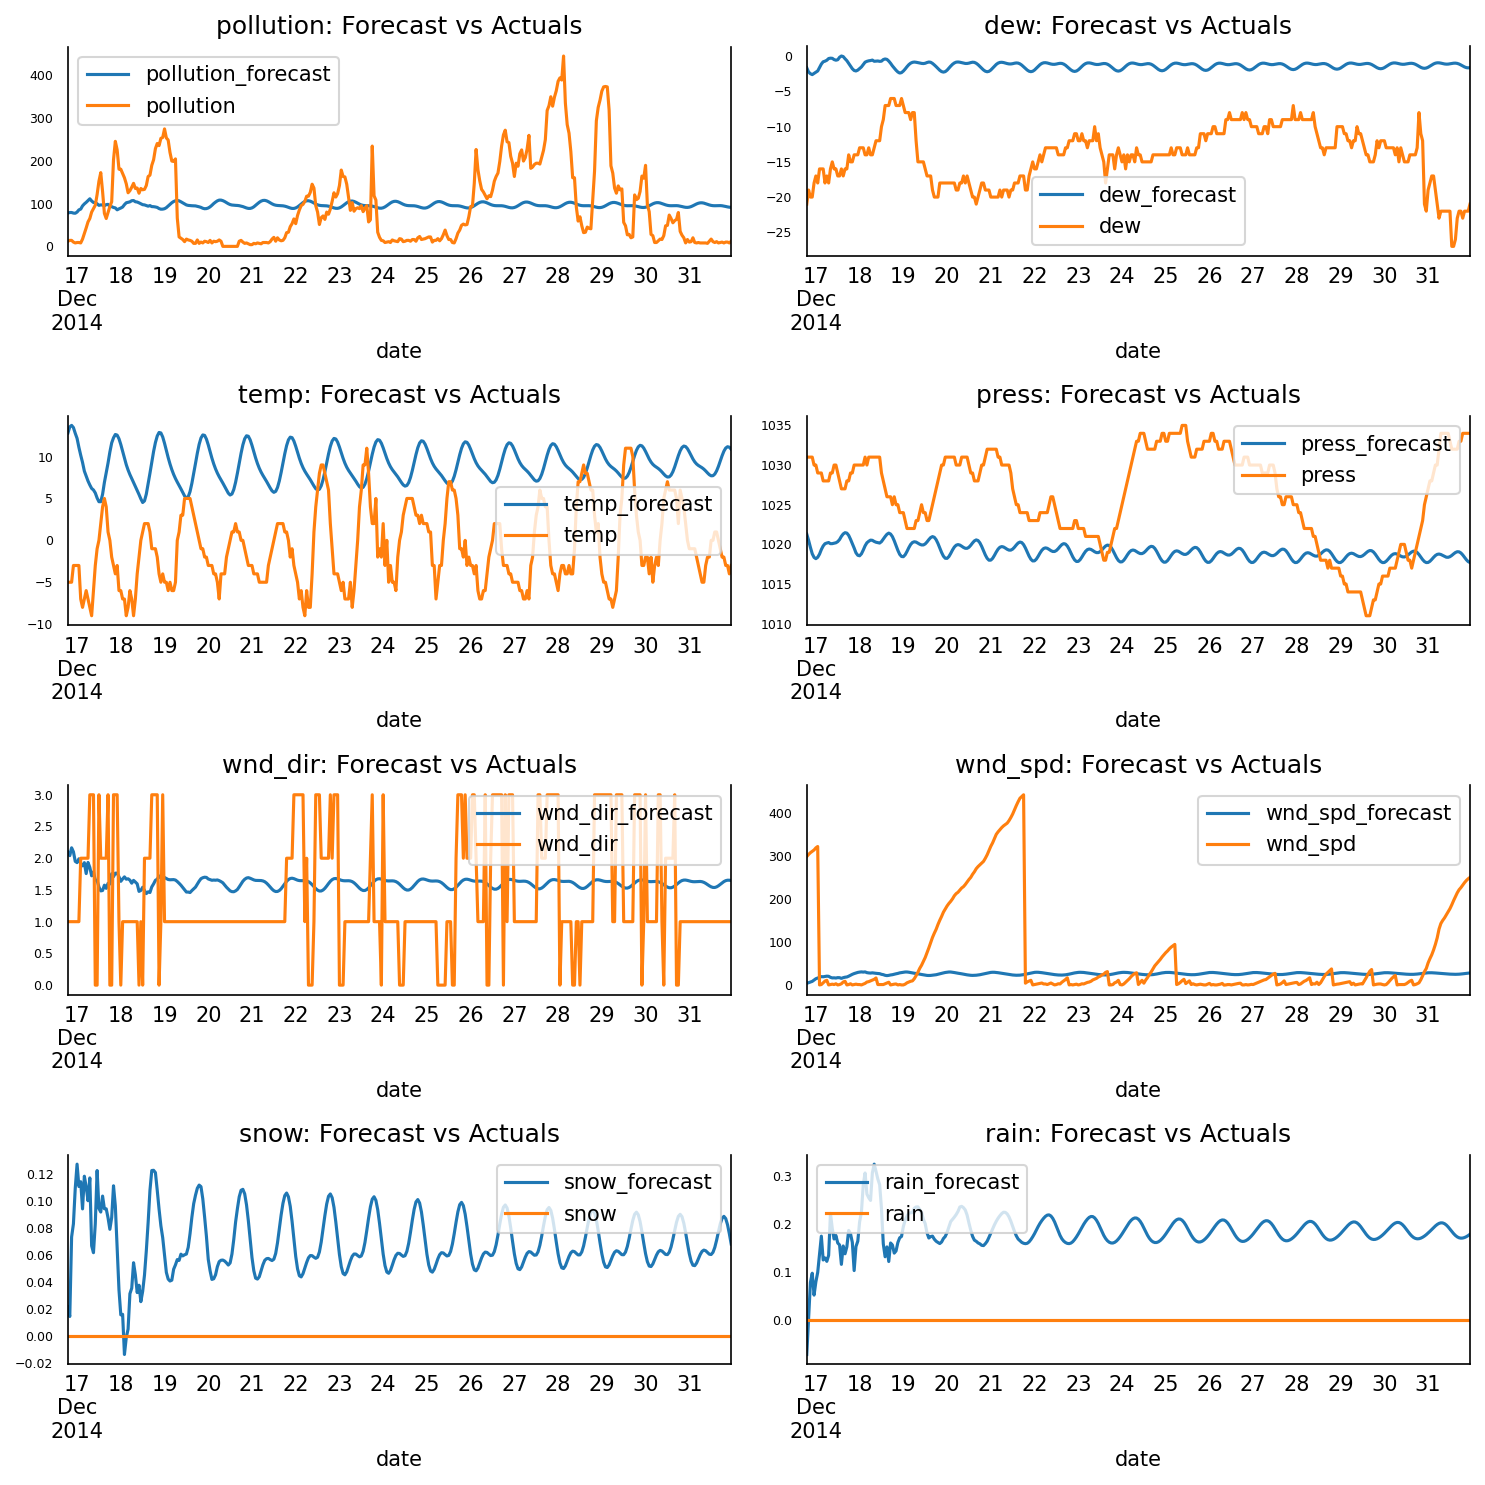

In [43]:
# Визуализация результатов
fig, axes = plt.subplots(nrows=int(len(cdf.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(cdf.columns, axes.flatten())):
    df_forecast[col].plot(legend=True, ax=ax, label=f"{str(col) + '_forecast'}").autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Судя по графикам модуль получилась неточной. Пробуем заново, но с другим количеством лагов.

In [48]:
# Разделяем выборку на train и test
cdf = data.copy()

train = cdf[:int(0.8*(len(data)))]
test = cdf[int(0.8*(len(data))):]

In [49]:
# Создаем модель VAR на основе обучающих данных
model = VAR(train)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [50]:
lag = 365;

# заполняем модель с подобранным параметром
model_fitted = model.fit(lag)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Mar, 2024
Time:                     14:57:14
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    14.1512
Nobs:                     34675.0    HQIC:                   10.2695
Log likelihood:          -516818.    FPE:                    4709.11
AIC:                      8.45405    Det(Omega_mle):         2465.69
--------------------------------------------------------------------
Results for equation pollution
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 47.650664        53.625420            0.889           0.374
L1.pollution           0.910978         0.005646          161.338           0.000
L1.dew                 1.875817         0.122719    

In [51]:
# данные для предсказания
forecast_input = train.values[-lag:]
forecast_input

array([[210.  , -13.  ,  -2.  , ...,   0.89,   0.  ,   0.  ],
       [247.  , -11.  ,  -2.  , ...,   1.78,   0.  ,   0.  ],
       [284.  , -12.  ,  -1.  , ...,   0.89,   0.  ,   0.  ],
       ...,
       [ 23.  , -21.  ,   7.  , ..., 125.6 ,   0.  ,   0.  ],
       [ 20.  , -21.  ,   6.  , ..., 130.52,   0.  ,   0.  ],
       [ 23.  , -20.  ,   7.  , ..., 137.67,   0.  ,   0.  ]])

In [52]:
# Forecast
nobs = 365 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=cdf.index[-nobs:], columns=cdf.columns)
df_forecast

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-12-16 19:00:00,33.743687,-20.430917,6.400859,1014.292078,0.922455,133.951003,-0.025573,0.065134
2014-12-16 20:00:00,37.317451,-20.244462,5.259333,1014.518536,1.083814,137.267099,0.098148,0.024754
2014-12-16 21:00:00,26.349486,-20.095247,4.556085,1014.750278,1.414889,124.904689,0.135983,-0.269209
2014-12-16 22:00:00,30.247237,-19.337220,3.710782,1014.663179,1.070821,123.726376,0.220280,0.004347
2014-12-16 23:00:00,31.490432,-19.396375,2.689778,1014.672822,1.012188,121.767898,0.145557,0.334075
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,116.750190,-11.840383,2.084890,1021.844080,1.620110,36.581629,-0.008545,-0.080590
2014-12-31 20:00:00,114.297902,-11.702998,2.135024,1021.776608,1.500566,37.093503,0.025462,-0.157456
2014-12-31 21:00:00,113.291426,-11.705420,1.827318,1021.592317,1.606454,34.586874,0.054360,-0.154516


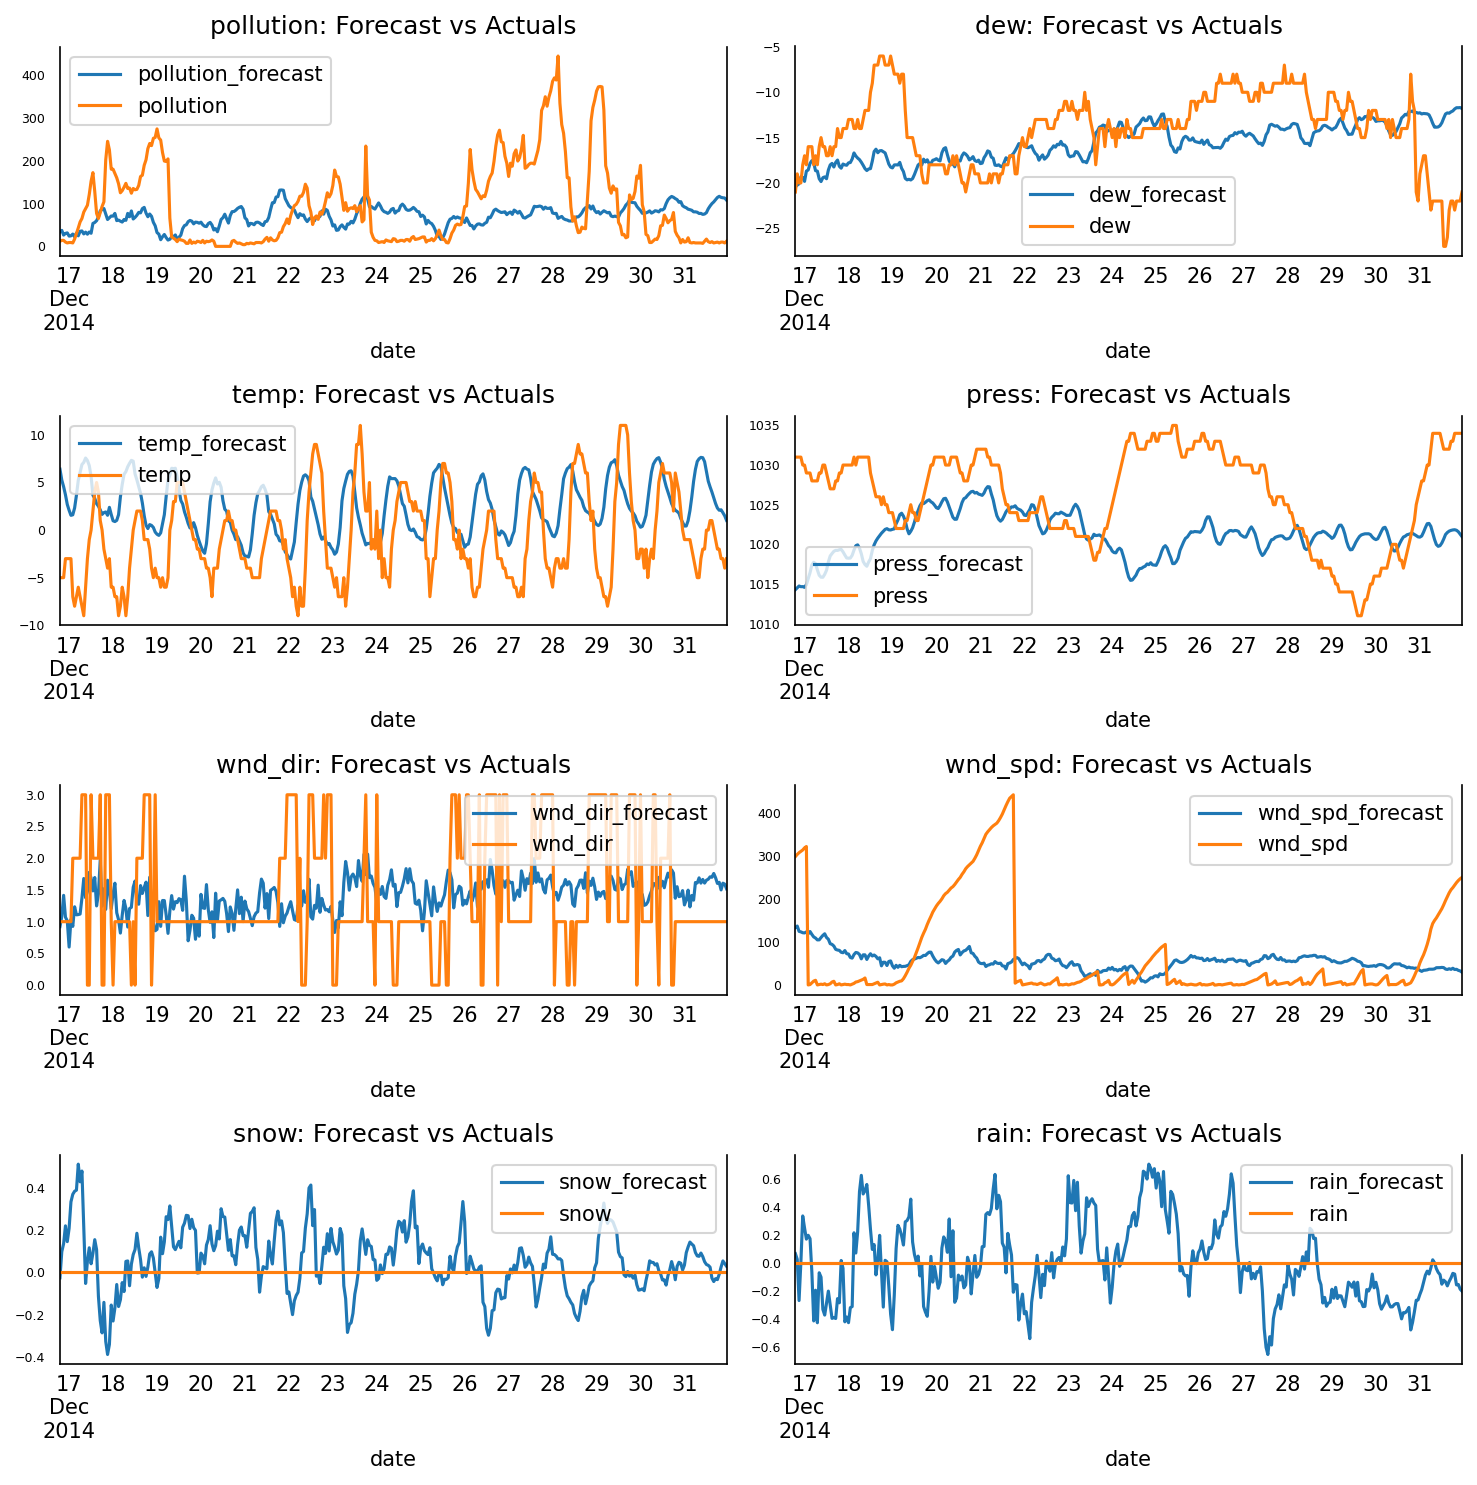

In [55]:
# Визуализация результатов
fig, axes = plt.subplots(nrows=int(len(cdf.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(cdf.columns, axes.flatten())):
    df_forecast[col].plot(legend=True, ax=ax, label=f"{str(col) + '_forecast'}").autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

При визуальном сравнении графиков видно, что с количеством лагов = 365 модель лучше справилась с предсказанием данных. Делаем вывод о том, что выбор порядка модели через *model.select_order(max_lag)* не всегда приводит к лучшим результатам.

**Оценка метрик VAR**

In [9]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def calculateMetrics(forecast_df, f_pred):
    rmse = np.sqrt(mean_squared_error(forecast_df, f_pred))
    mae = mean_absolute_error(forecast_df, f_pred)
    r2 = r2_score(forecast_df, f_pred)
    mape = np.mean(np.abs((forecast_df - f_pred) / forecast_df)) * 100
    
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("MAE:", mae)
    print("R2: ", r2)
    print("\n")

In [68]:
cols = test.columns.to_list()

for vi in range(len(cols)):
    print(f'Metrics for {cols[vi]}')
    n1 = f"{cols[vi]}"
    calculateMetrics(df_forecast[n1].values, np.array(test.iloc[len(test) - 365: len(test),vi]))


Metrics for pollution
RMSE: 101.53884627816751
MAPE: 124.24479145686871
MAE: 78.22833383429217
R2:  -17.779814636213782


Metrics for dew
RMSE: 4.665129220804395
MAPE: 23.383008482574805
MAE: 3.5600630204727377
R2:  -4.072301287654599


Metrics for temp
RMSE: 6.140222191331608
MAPE: 406.3998157926238
MAE: 4.918856054625812
R2:  -3.8359319893814616


Metrics for press
RMSE: 8.475763453244575
MAPE: 0.6787443245573321
MAE: 6.9229427866741835
R2:  -9.352632346138174


Metrics for wnd_dir
RMSE: 0.9348158467897519
MAPE: 53.80848073652948
MAE: 0.7656785081014975
R2:  -11.674295241415127


Metrics for wnd_spd
RMSE: 110.74577127462886
MAPE: 153.0243211508699
MAE: 80.14973831687796
R2:  -27.268819949869876


Metrics for snow
RMSE: 0.155019394831165
MAPE: 100.0
MAE: 0.12090613736013679
R2:  -0.16715058477222722


Metrics for rain
RMSE: 0.2814502177473814
MAPE: 100.0
MAE: 0.22676427560099202
R2:  -6.0755107016863263e-05




Модель VAR имеет различную степень точности для разных временных рядов






**Нейронная сеть**

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Функция преобразования данных, чтобы скормить их модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [13]:
ndf = data.copy()

# LSTM
# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
pollution_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(ndf)
scaled_pollution = pollution_scaler.fit_transform(ndf[['pollution']])

train_length = int(len(scaled_data) * 0.8)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [14]:
look_back = 1
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [16]:
# Архитектура LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Обучение
model.fit(X_train, Y_train, epochs=30, batch_size=1, verbose=2)

Epoch 1/30


35038/35038 - 50s - 1ms/step - loss: 9.7948e-04
Epoch 2/30
35038/35038 - 45s - 1ms/step - loss: 8.6562e-04
Epoch 3/30
35038/35038 - 48s - 1ms/step - loss: 8.4162e-04
Epoch 4/30
35038/35038 - 44s - 1ms/step - loss: 8.2422e-04
Epoch 5/30
35038/35038 - 47s - 1ms/step - loss: 8.1731e-04
Epoch 6/30
35038/35038 - 48s - 1ms/step - loss: 8.0201e-04
Epoch 7/30
35038/35038 - 46s - 1ms/step - loss: 8.0202e-04
Epoch 8/30
35038/35038 - 45s - 1ms/step - loss: 8.0134e-04
Epoch 9/30
35038/35038 - 48s - 1ms/step - loss: 7.9819e-04
Epoch 10/30
35038/35038 - 54s - 2ms/step - loss: 7.9713e-04
Epoch 11/30
35038/35038 - 51s - 1ms/step - loss: 7.9409e-04
Epoch 12/30
35038/35038 - 48s - 1ms/step - loss: 7.9381e-04
Epoch 13/30
35038/35038 - 47s - 1ms/step - loss: 7.9479e-04
Epoch 14/30
35038/35038 - 50s - 1ms/step - loss: 7.9358e-04
Epoch 15/30
35038/35038 - 49s - 1ms/step - loss: 7.9392e-04
Epoch 16/30
35038/35038 - 53s - 2ms/step - loss: 7.9200e-04
Epoch 17/30
35038/35038 - 49s - 1ms/step - loss: 7.9222e-04


In [18]:
# Предсказание
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [19]:
# Обратное преобразование для масштабирования
train_predict = pollution_scaler.inverse_transform(train_predict)
Y_train = pollution_scaler.inverse_transform([Y_train])
test_predict = pollution_scaler.inverse_transform(test_predict)
Y_test = pollution_scaler.inverse_transform([Y_test])

In [21]:
# Создание DataFrame для предсказаний LSTM
lstm_predictions = pd.DataFrame(test_predict, index=ndf.index[-len(test_predict):], columns=['LSTM_prediction'])

# Объединение исходных данных и предсказаний
ndf = pd.concat([ndf, lstm_predictions], axis=1)

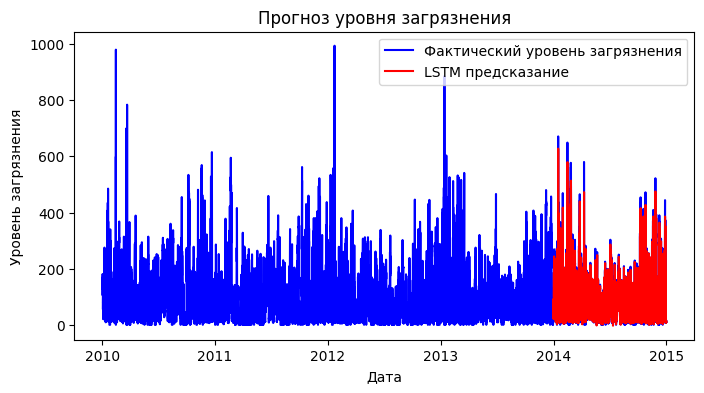

In [22]:
# Визуализация результатов
plt.figure(figsize=(8,4))
plt.plot(ndf['pollution'], color='blue', label='Фактический уровень загрязнения')
plt.plot(ndf['LSTM_prediction'], color='red', label='LSTM предсказание')
plt.title('Прогноз уровня загрязнения')
plt.xlabel('Дата')
plt.ylabel('Уровень загрязнения')
plt.legend()
plt.show()

In [26]:
# Метрики для модели LSTM
lstm_true = ndf['pollution'].iloc[-len(test_predict):].values
lstm_pred = ndf['LSTM_prediction'].dropna().values
print("\nMetrics for LSTM:")
calculateMetrics(lstm_true, lstm_pred)


Metrics for LSTM:
RMSE: 34.33345469494128
MAPE: inf
MAE: 19.408185676635195
R2:  0.8653768650652289




C:\Users\User\AppData\Local\Temp\ipykernel_18136\193124967.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((forecast_df - f_pred) / forecast_df)) * 100


**Заключение по LSTM и работе в целом**

